# Eurozone consumer prices inflation, ECB Deposit Facility, Market Yield on Government Bonds at 10-Year, wage inflation, and Riskless Yield Curve
This notebook jaxteposes the evolution of Eurozone consumer prices inflation as measured by the HICP (Harmonized Index of Consumer Prices) with ECB Deposit Facility Rate and 10 year Government Bond yields. It then looks at the the relationship between riskfree rates (e.g. 10-year AAA-rated eurozone central government bonds rates) and Eurozone HICP + real GDP growth rates. HICP + GDP growth rates is known as _the intrinsic riskfree rate_. In theory the 10-year AAA-rated eurozone central government bond rate such as that for 10-Year Germany government bonds should be similar to the intrinsic riskfree rate. This notebook looks at how this played out since the 90's.

I then look at Euroarea wage inflation data.

Finally, I look at the evolution of the Euro riskless rate curve as defined by the yields on AAA-rated eurozone central government bonds.

**NB**: Throughout this notebook in datasets with a quarterly frequency, data indexed to the start of a quarter designates the whole quarter starting on that date.

In [1]:
# Uncomment if running in Google Colaboratory, otherwise the import of the curves module in the cell below will fail
#!git clone -l -s https://github.com/ilchen/US_Economic_Data_Analysis.git cloned-repo
#%cd cloned-repo

# Install the latest version of eurostat
# !pip install eurostat -U

In [2]:
import pandas as pd
import numpy as np
import matplotlib.ticker as mtick
import pandas_datareader.data as web
from pandas.tseries.offsets import MonthBegin, BDay, QuarterBegin

import eurostat

from datetime import date
import re

from dateutil.relativedelta import relativedelta

from pricing import curves

In [3]:
report_start = date.fromisoformat('1996-01-01')
report_end = date.today()

### Get Consumer Price Index for the Eurozone, ECB Deposit Facility Rate, 10 Year Government Bond Yields, and Real GDP
I use the following dataseries provided by [FRED](https://fred.stlouisfed.org/):
* `ECBDFR` &mdash; ECB Deposit Facility Rate for Euro Area (daily frequency, from 1999)
* `ECBMLFR` &mdash; ECB Marginal Lending Facility Rate for Euro Area (daily frequency, from 1999). This is the rate at which banks can borrow money from the central bank against collateral for a period of one day (overnight). This rate is always higher than the main refinancing rate and therefore sets an upper limit for money market rates.

And the following dataseries provided by the [Eurostat](https://ec.europa.eu/eurostat/web/main/data/database):
* `irt_lt_mcby_m` &mdash; EMU convergence criterion series (monthly frequency). This series returns a dataset containing Long-Term Government Bond Yields for the Eurozone at 10-year maturity. I use it instead of the `IRLTLT01DEM156N` and `IRLTLT01ITM156N` datasets returned by FRED given that Eurostat's database tends to be updated earlier than that of FRED for Eurozone data.
* `prc_hicp_midx` &mdash; Harmonized Index of Consumer Prices: All Items for the Eurozone (monthly frequency, 2015=100, from 1996)

There's a relationship between the riskless rate as represented by AAA-rated eurozone central government bonds rates on the one hand and real GDP growth and inflation rates on the other hand. I use 10-year Germany Bond Yields as proxy for riskless long-term rates in the Eurozone given Germany's AAA credit rating. At the end of this section I look at real GDP developments in conjunction with the inflation of consumer prices. To calculate GDP growth for the Euro area I make use of the following dataseries from [Eurostat](https://ec.europa.eu/eurostat/databrowser/view/NAMQ_10_GDP/default/table?lang=en):
* `namq_10_gdp` — Real Gross Domestic Product for the Eurozone, Millions of Chained 2010 Euros (quarterly frequency, from 1996). The closest series published by the FRED is `CLVMEURSCAB1GQEA19`, however it is still based on the old configuration of the Eurozone (EA19) so I don't use it. I make use of both non seasonally adjusted as well as seasonally and calendar adjusted data. This is needed because I want to obtain both annual GDP growth (i.e. growth over four quarters) as well as quarterly GDP growth and express the latter at an annual rate. I use the following formula to translate quarterly changes into annual rates:

$$\left(\left({\text{level of quarter n+1} \over \text{level of quarter n}}\right)^4-1\right)\times 100\% $$

In [4]:
ecbr = web.get_data_fred(['ECBDFR', 'ECBMLFR'], start=report_start, end=report_end)

# Retrieving the most recent Eurozone CPI and government bond yields from Eurostat's database
EUROSTAT_DE_COUNTRY_LABEL = 'DE'
EUROSTAT_IT_COUNTRY_LABEL = 'IT'
eu_irt_lt = eurostat.get_data_df('irt_lt_mcby_m',
        filter_pars={'startPeriod': report_start, 'geo': ['DE', 'IT']}).iloc[:, 2:]
eu_irt_lt = eu_irt_lt.set_index(eu_irt_lt.columns[0]).T
eu_irt_lt = eu_irt_lt.set_axis(pd.DatetimeIndex(eu_irt_lt.index, 'MS'))

# Using Eurozone price index 2015=100, and All-items HICP: CP00 
eu_hicp = eurostat.get_data_df('prc_hicp_midx',
               filter_pars={'startPeriod': report_start, 'unit': 'I15', 'coicop': 'CP00', 'geo': 'EA'}).iloc[:, 3:]
eu_hicp = eu_hicp.set_index(eu_hicp.columns[0]).T
eu_hicp = eu_hicp.set_axis(pd.DatetimeIndex(eu_hicp.index, 'MS'))
# Since prc_hicp_midx is indexed to 2015=100, we need to convert it to annual percentage changes
eu_hicp_annual = eu_hicp.pct_change(12)

# Make frequencies explicit, resample to month srart
ecbr = ecbr.asfreq('D').resample('MS').last()

# Merge and truncate to start of celendar year 1999.
cpi_ecbr_irtlt = pd.concat([eu_hicp_annual, eu_irt_lt, ecbr], axis=1).loc['1997':]

cpi_ecbr_irtlt = cpi_ecbr_irtlt[['EA', 'ECBDFR', 'ECBMLFR', 'DE', 'IT']]

DE_YIELD_LABEL = '10y German Government Bond Yield'
IT_YIELD_LABEL = '10y Italian Government Bond Yield'
ECB_DEPOSIT_RATE_LABEL = 'ECB Deposit Facility Rate'
GRAPH_TITLE_HICP = 'Eurozone annual HICP, ECB Deposit Facility and Marginal Lending Rates, and 10y Government Bond Yields'
GRAPH_TITLE_HICP_2 = 'Eurozone annual HICP, ECB Deposit Facility, and 10y Government Bond Yields'
cpi_ecbr_irtlt.rename(
    columns={'EA': 'Annual Eurozone HICP',
             'ECBDFR': ECB_DEPOSIT_RATE_LABEL, 'ECBMLFR': 'ECB Marginal Lending Facility Rate',
             EUROSTAT_DE_COUNTRY_LABEL: DE_YIELD_LABEL,
             EUROSTAT_IT_COUNTRY_LABEL: IT_YIELD_LABEL},
    inplace=True)

# Querying for non seasonally adjusted, seasonally and calendar adjusted all-items Eurozone GDP data
# in chained linked volumes of 2010
real_gdp = eurostat.get_data_df('namq_10_gdp', filter_pars={
    'startPeriod': report_start, 'unit': 'CLV10_MEUR', 's_adj': ['NSA', 'SCA'], 'na_item': 'B1GQ', 'geo': 'EA'}).iloc[:, 4:]
real_gdp = real_gdp.set_index(real_gdp.columns[0]).T
real_gdp = real_gdp.set_axis(pd.DatetimeIndex(real_gdp.index, 'QS'))

# Seasonally adjusted data is in the second column, it is more suitable for extrapolating GDP quarterly growth
# at an annual rate
real_gdp_quarterly = ((real_gdp.iloc[:,1]/real_gdp.iloc[:,1].shift(1)).pow(4)-1)
real_gdp = real_gdp.iloc[:,:1]
real_gdp.rename(columns={'EA': 'Real GDP'}, inplace=True)

# To calculate the annual rate of GDP growth I sum up the non-seasonally adjusted GDP over the last 4 quarters.
# If Eurostat were publishing seasonally adjusted GDP data at annual volumes (as is the case in the US),
# I could calculate the mean over the past 4 quarters and use it as the actual annual GDP. 
real_gdp = real_gdp.rolling(4).sum().pct_change(4, fill_method='bfill')
real_gdp['Real GDP over quarter at annual rate'] = real_gdp_quarterly
real_gdp = real_gdp.loc['1997':]
real_gdp.columns.names = [None]

In [5]:
# Calculate the mean rate for the current month and, if needed, for the one before too
rmth_start = cpi_ecbr_irtlt.index[-2 if pd.isna(cpi_ecbr_irtlt.iloc[-2, -1]) else -1].date()

eu_irt_lt_cur_mth = eurostat.get_data_df('irt_lt_mcby_d',
        filter_pars={'startPeriod': rmth_start, 'geo': ['DE', 'IT']}).iloc[:, 2:]
eu_irt_lt_cur_mth = eu_irt_lt_cur_mth.set_index(eu_irt_lt_cur_mth.columns[0]).T
eu_irt_lt_cur_mth = eu_irt_lt_cur_mth.set_axis(pd.DatetimeIndex(eu_irt_lt_cur_mth.index, 'B'))
eu_irt_lt_cur_mth.rename(
    columns={EUROSTAT_DE_COUNTRY_LABEL: DE_YIELD_LABEL,
             EUROSTAT_IT_COUNTRY_LABEL: IT_YIELD_LABEL},
    inplace=True)
eu_irt_lt_cur_mth = eu_irt_lt_cur_mth.asfreq('D').resample('MS').mean()
cpi_ecbr_irtlt.loc['2022':, [DE_YIELD_LABEL, IT_YIELD_LABEL]].update(eu_irt_lt_cur_mth)
cpi_ecbr_irtlt.update(eu_irt_lt_cur_mth)

# Convert to percentage points
cpi_ecbr_irtlt.iloc[:,[1,2,3,4]] /= 100

In [6]:
pd.options.display.float_format = '{:.4%}'.format
cpi_ecbr_irtlt.dropna(subset=[ECB_DEPOSIT_RATE_LABEL, DE_YIELD_LABEL, IT_YIELD_LABEL])

,Annual Eurozone HICP,ECB Deposit Facility Rate,ECB Marginal Lending Facility Rate,10y German Government Bond Yield,10y Italian Government Bond Yield
1999-01-01,0.7650%,2.0000%,4.5000%,3.7000%,3.9200%
1999-02-01,0.7357%,2.0000%,4.5000%,3.8500%,4.0500%
1999-03-01,0.9393%,2.0000%,4.5000%,4.0400%,4.2700%
1999-04-01,1.0732%,1.5000%,3.5000%,3.8500%,4.1100%
1999-05-01,0.9355%,1.5000%,3.5000%,4.0100%,4.2800%
...,...,...,...,...,...
2024-04-01,2.3717%,4.0000%,4.7500%,2.4500%,3.8600%
2024-05-01,2.5660%,4.0000%,4.7500%,2.5200%,3.8400%
2024-06-01,2.5188%,3.7500%,4.5000%,2.4800%,3.9400%
2024-07-01,2.5778%,3.7500%,4.5000%,2.4600%,3.8300%


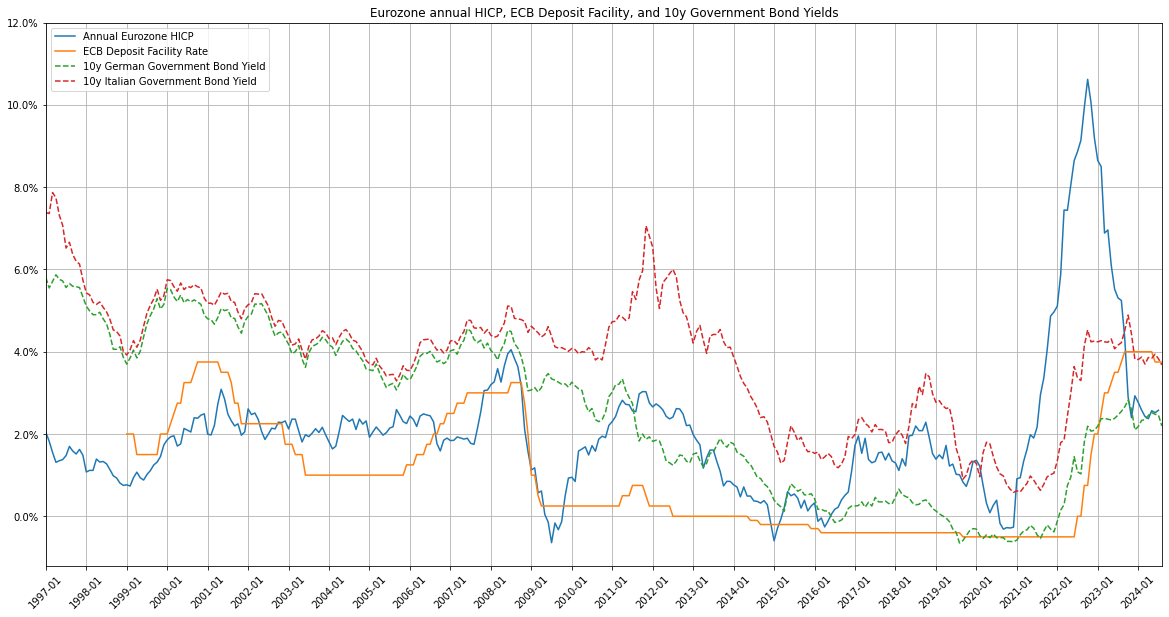

In [7]:
ax = cpi_ecbr_irtlt.iloc[:,:2].plot(figsize=(20,10), grid=True,
                        title=GRAPH_TITLE_HICP_2,
                        xticks=cpi_ecbr_irtlt.index[::12], xlabel='', rot=45, yticks=np.arange(0, .13, .02))
cpi_ecbr_irtlt.iloc[:,3:].plot(ax=ax, linestyle='--', grid=True,
                        xticks=cpi_ecbr_irtlt.index[::12], xlabel='', rot=45, yticks=np.arange(0, .13, .02))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, cpi_ecbr_irtlt.index[::12])))

#### Eurozone HICP  based on monthly and quarterly changes
In the previous part of this notebook I looked at HICP based on changes compared to 12 months ago. This is the standard way of determining annual percentage cahnges. Below I look at monthly changes in HICP and then translate them into annual percentage changes using the following simple formula for translating monthly HICP changes into annual percentage changes:

$$\left(\left({\text{level of month n+1} \over \text{level of month n}}\right)^{12}-1\right)\times 100\% $$

And then the same for translating quarterly changes into annual rates:

$$\left(\left({\text{level of month n+1} \over \text{level of month n-2}}\right)^4-1\right)\times 100\% $$

In [8]:
from_date = date(2020, 1, 1)
eu_hicp_monthly = eu_hicp.pct_change(fill_method='bfill').loc[from_date:, 'EA']
eu_hicp_monthly.rename('Eurozone HICP Change over Prev Month', inplace=True)
eu_hicp_annual = ((eu_hicp/eu_hicp.shift(1)).pow(12)-1).loc[from_date:, 'EA'].rename('Eurozone HICP Change over Prev Month at Annual Rate')
eu_hicp_quarterly = ((eu_hicp/eu_hicp.shift(3)).pow(4)-1).loc[from_date:, 'EA'].rename('Eurozone HICP Change over Prev 3 Months at Annual Rate')

In [9]:
eu_hicp_df = pd.concat([cpi_ecbr_irtlt.loc[from_date:, cpi_ecbr_irtlt.columns[0]], eu_hicp_quarterly, eu_hicp_annual], axis=1).dropna()

In [10]:
eu_hicp_df.tail(12)

,Annual Eurozone HICP,Eurozone HICP Change over Prev 3 Months at Annual Rate,Eurozone HICP Change over Prev Month at Annual Rate
2023-08-01,5.2440%,2.8891%,6.7158%
2023-09-01,4.3351%,3.1465%,3.9394%
2023-10-01,2.9001%,3.8814%,1.0660%
2023-11-01,2.3977%,-0.5792%,-6.4496%
2023-12-01,2.9290%,-1.2160%,1.9551%
2024-01-01,2.7688%,-2.9851%,-4.2673%
2024-02-01,2.5817%,1.6901%,7.7373%
2024-03-01,2.4277%,4.1252%,9.4564%
2024-04-01,2.3717%,8.1334%,7.2191%
2024-05-01,2.5660%,6.3870%,2.6011%


In [11]:
import seaborn as sns
cm = sns.color_palette('Blues', as_cmap=True)
IDX_FORMAT = '{:%Y-%m}'

In [12]:
eu_hicp_df = eu_hicp_df.loc[from_date:, eu_hicp_df.columns[0:2]]
eu_hicp_df.tail(18).style.format_index(IDX_FORMAT).format('{:.2%}')\
    .set_properties(subset=eu_hicp_df.columns, **{'width': '200px'})\
    .set_table_styles([{'selector': 'th', 'props': 'text-align: right; width: 100px'}])\
    .background_gradient(cmap=cm)

,Annual Eurozone HICP,Eurozone HICP Change over Prev 3 Months at Annual Rate
2023-02,8.50%,0.96%
2023-03,6.88%,6.18%
2023-04,6.96%,9.82%
2023-05,6.10%,6.45%
2023-06,5.52%,3.75%
2023-07,5.31%,0.78%
2023-08,5.24%,2.89%
2023-09,4.34%,3.15%
2023-10,2.90%,3.88%
2023-11,2.40%,-0.58%


#### Eurozone Real GDP growth
I present both growth over the last 4 quarters as well as growth over one quarter, both expressed as annual percentage rates. For growth over one quarter (the 2<sup>nd</sup> column) I use seasonally and calendar adjusted data (Eurostat code `SCA`). For growth over the last 4 quarters (which provides the official annual growth) I use unadjusted data (Eurostat code `NSA`). Unfortunately Eurostat tends to delay publishing unadujusted data, as a result you might occasionally see a NaN value in the last row for it.

In [13]:
# real_gdp.loc['2020':]
real_gdp.tail(18).style.format_index(IDX_FORMAT).format('{:.2%}')\
    .set_properties(subset=real_gdp.columns, **{'width': '200px'})\
    .set_table_styles([{'selector': 'th', 'props': 'text-align: right; width: 100px'}])\
    .background_gradient(cmap=cm)

,Real GDP,Real GDP over quarter at annual rate
2020-01,0.53%,-12.75%
2020-04,-3.37%,-37.58%
2020-07,-4.88%,55.71%
2020-10,-6.01%,0.48%
2021-01,-5.43%,1.58%
2021-04,1.41%,9.54%
2021-07,3.71%,8.32%
2021-10,6.04%,2.30%
2022-01,7.54%,2.37%
2022-04,5.01%,3.60%


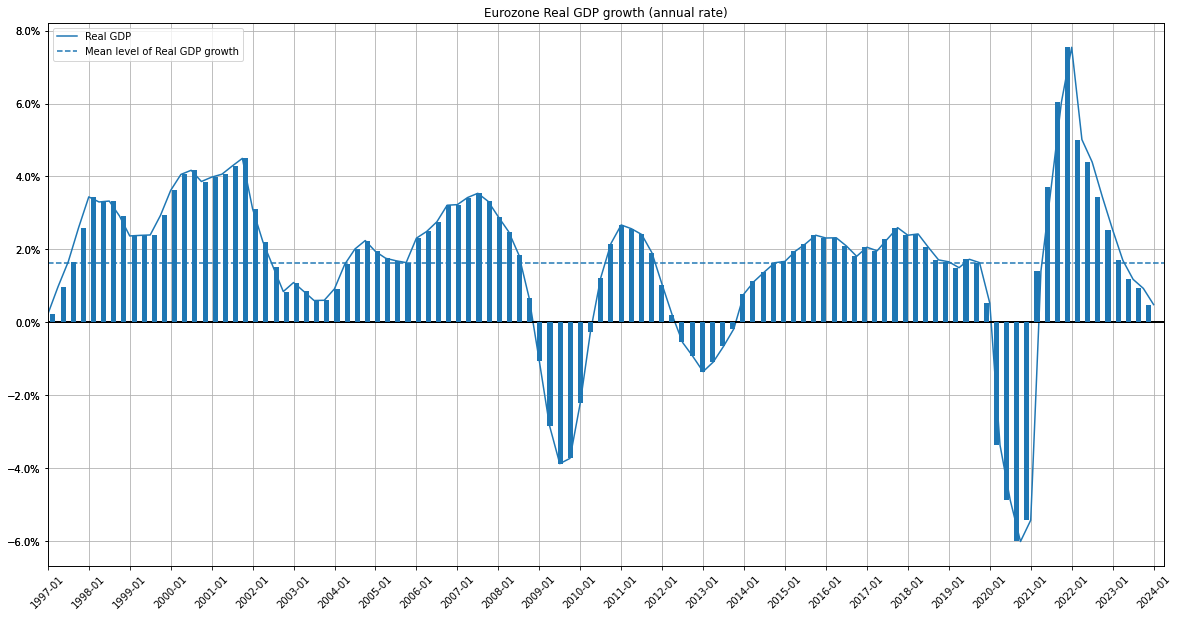

In [14]:
ax = real_gdp.iloc[:,0].plot(figsize=(20,10), grid=True, title='Eurozone Real GDP growth (annual rate)',
                   xticks=real_gdp.index[::4], xlabel='', rot=45)#, yticks=np.arange(-.15, .2, 0.025))
ax.axhline(y=0, lw=2, c='k')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax2 = ax.twiny()
real_gdp.iloc[:,0].plot.bar(ax=ax2, xlabel='', legend=False)
ax.axhline(y=real_gdp.iloc[:,0].mean(), ls='--', c='#1f77b4', label='Mean level of Real GDP growth')
ax.legend()
ax2.xaxis.set_major_locator(mtick.NullLocator())
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, real_gdp.index[::4])))

In [15]:
print(f'Mean level of annual rate of real GDP growth in the Euro area since {real_gdp.index[0]:%Y-%m-%d}: '
      f'{real_gdp.iloc[:,0].mean():.2%}')

Mean level of annual rate of real GDP growth in the Euro area since 1997-01-01: 1.63%


In [16]:
# Including only the yield on German government bonds as those of Italy are not AAA rated and cannot be regarded
# as riskfree
df = pd.concat([real_gdp.iloc[:,0], cpi_ecbr_irtlt.iloc[:,[0,3]].resample('qs').mean()], axis=1)\
    .loc[:real_gdp.last_valid_index()] # Truncate based on last valid GDP value
df.loc['2020':]

,Real GDP,Annual Eurozone HICP,10y German Government Bond Yield
2020-01-01,0.5280%,1.1090%,-0.4400%
2020-04-01,-3.3654%,0.2217%,-0.4667%
2020-07-01,-4.8798%,-0.0313%,-0.5200%
2020-10-01,-6.0110%,-0.2754%,-0.6133%
2021-01-01,-5.4265%,1.0597%,-0.4633%
2021-04-01,1.4116%,1.8360%,-0.2800%
2021-07-01,3.7060%,2.8279%,-0.4500%
2021-10-01,6.0418%,4.6274%,-0.3000%
2022-01-01,7.5422%,6.1422%,0.1033%
2022-04-01,5.0114%,8.0453%,1.0500%


### Visualizing the relationship between 10y German Bund Yield and the Intrinsic Riskfree rate (real GDP growth + inflation rates)
I use Germany 10-year government bond yield as a representative of a Eurozone central government bond with an AAA credit rating in the below graph. It is a proxy for the actual long-term riskfree rate in the Eurozone. I compare it with the intrinsic riskfree rate as defined by the sum of real GDP growth and inflation rates.

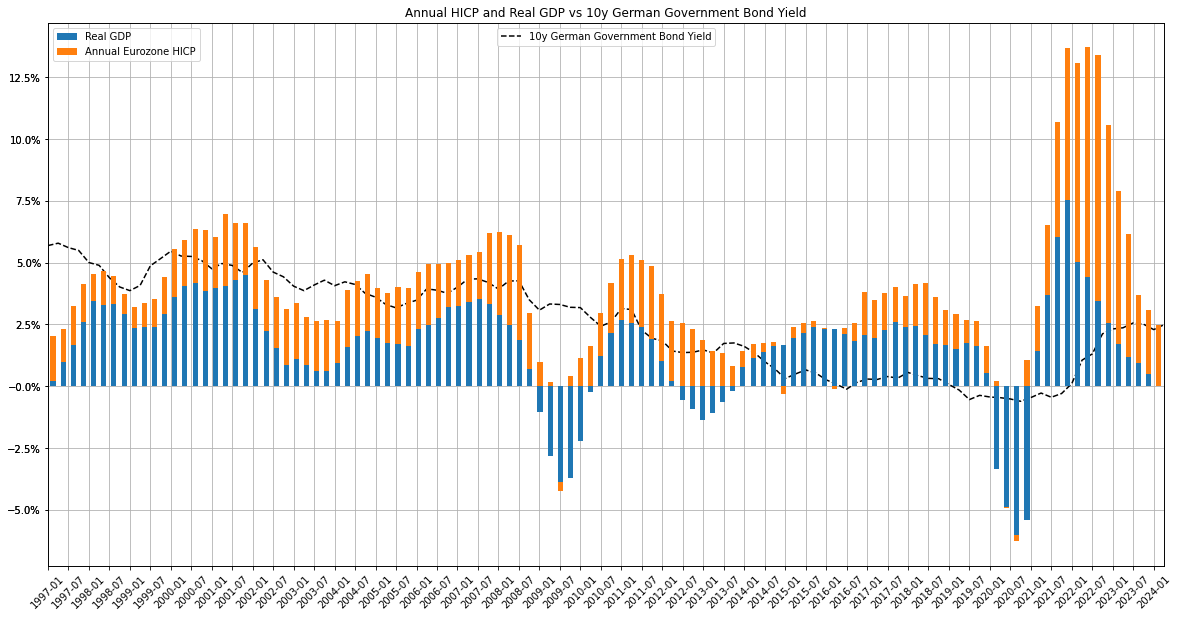

In [17]:
ax = df.iloc[:, -1].plot(figsize=(20,10), grid=True,
                         title='Annual HICP and Real GDP vs ' + DE_YIELD_LABEL,
                         xticks=df.index[::2], xlabel='', rot=45,
                         yticks=np.arange(-.15, .2, 0.025), linestyle='--', color='k')
ax2 = ax.twiny()
df.iloc[:,[0,1]].plot.bar(ax=ax2, xlabel='', stacked=True)
ax.legend(loc='upper center')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax2.xaxis.set_major_locator(mtick.NullLocator())
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, df.index[::2])))

In [18]:
print('Gap between intrinsic (GDP+HICP) and actual (10-y German Bund) riskfree rates: {:.2%}\n'
      'Compared with: {:.2%} one quarter earlier'.format(
    df.iloc[-1,0] + df.iloc[-1,1] - df.iloc[-1,2], df.iloc[-2,0] + df.iloc[-2,1] - df.iloc[-2,2]))

Gap between intrinsic (GDP+HICP) and actual (10-y German Bund) riskfree rates: nan%
Compared with: 0.79% one quarter earlier


In [19]:
print('Average gap between intrinsic (GDP+HICP) and actual (10-y German Bund) riskfree rates since {:%Y-%m}: {:.2%}'
      .format(df.index[0], df.iloc[:,0].mean() + df.iloc[:,1].mean() - df.iloc[:,2].mean()))

Average gap between intrinsic (GDP+HICP) and actual (10-y German Bund) riskfree rates since 1997-01: 1.11%


In [20]:
from_dt = date(2009, 1, 1)
means = df.loc[from_dt:].mean()
print('Average gap between intrinsic (GDP+HICP) and actual (10-y German Bund) riskfree rates since {:%Y-%m}: {:.2%}'
      .format(from_dt, means.iloc[0] + means.iloc[1] - means.iloc[2]))

Average gap between intrinsic (GDP+HICP) and actual (10-y German Bund) riskfree rates since 2009-01: 1.89%


## A quick look at wage inflation in the Eurozone
In contrast to U.S. Bureau of Labor Statistics, unfortunately Eurostat typically lags by one quarter in publishing data on wage inflation and publishes them only with quarterly frequencies.

I use the following dataseries provided by [Eurostat](https://ec.europa.eu/eurostat/web/main/data/database):
* `lc_lci_r2_q` &mdash; Labour cost index by NACE Rev. 2 activity - nominal value, quarterly data. This series returns a MultiIndexed dataset containing different views on this data for the Eurozone as a whole as whell as for each individual country in the EU.

In [21]:
# Seasonally and calendar-adjusted, 2020=100
# NACE Rev 2. Sections B to S from 2009Q1 onward
# Labour cost for LCI (compensation of employees plus taxes minus subsidies): D1_D4_MD5
eu_wagei = eurostat.get_data_df('lc_lci_r2_q',
        filter_pars={'startPeriod': report_start, 's_adj': 'SCA', 'unit': 'I20',
                     'nace_r2': 'B-S', 'lcstruct': 'D1_D4_MD5', 'geo': 'EA'}).iloc[:, 5:]
eu_wagei = eu_wagei.set_index(eu_wagei.columns[0]).T
eu_wagei = eu_wagei.set_axis(pd.DatetimeIndex(eu_wagei.index, 'QS'))
eu_wagei.dropna(inplace=True)
eu_wagei_quarterly = (eu_wagei/eu_wagei.shift()).pow(4) - 1
eu_wagei_quarterly.rename(columns={'EA': 'Hourly Earnings Change Over Last Quarter at Annual Rate'}, inplace=True)
eu_wagei = eu_wagei.pct_change(4, fill_method='bfill').dropna()
eu_wagei.rename(columns={'EA': 'Hourly Earnings Annual Percentage Change'}, inplace=True)

cpi_and_wagei = pd.concat([cpi_ecbr_irtlt.iloc[:,0].resample('qs').last().loc[eu_wagei.index[0]:], eu_wagei], axis=1)\
     .loc[:date.today()-relativedelta(months=+3)]

In [22]:
# Mean level of Wage Inflation, and HICP
mean_level_wagei = eu_wagei.iloc[:,0].mean()
mean_level_cpi = cpi_ecbr_irtlt.iloc[:,0].mean()

LABEL_MEAN_WAGEI = 'Mean Level of Annual Changes in Labour Costs'
LABEL_MEAN_CPI = 'Mean Level of Annual Changes in HICP'

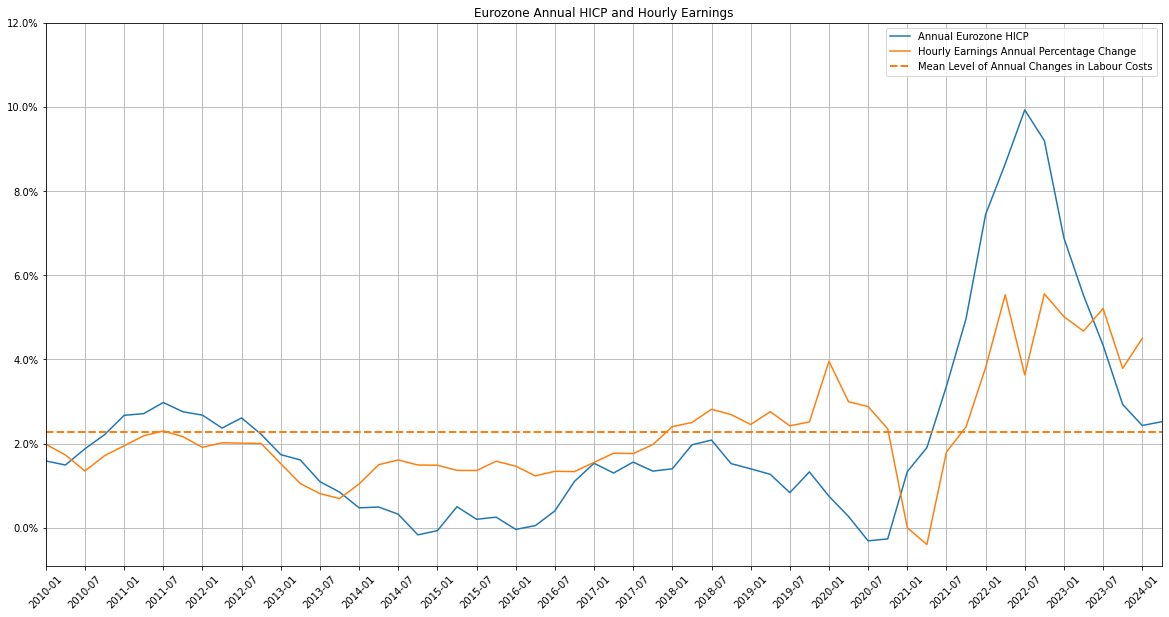

In [23]:
ax = cpi_and_wagei.plot(figsize=(20,10), grid=True,
                        title='Eurozone Annual HICP and Hourly Earnings',
                        xticks=cpi_and_wagei.index[::2], xlabel='', rot=45, yticks=np.arange(0, .13, .02))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
#ax.axhline(y=mean_level_cpi, lw=2, ls='--', c='#1f77b4', label=LABEL_MEAN_CPI)
ax.axhline(y=mean_level_wagei, lw=2, ls='--', c='#ff7f0e', label=LABEL_MEAN_WAGEI)
ax.legend()
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, cpi_and_wagei.index[::2])))

In [24]:
print('Labour costs annual growth {:+.2%} above the historic mean of {:.2%} in quarter starting on {:%Y-%m-%d}'
      .format(eu_wagei.iloc[-1,0]-mean_level_wagei, mean_level_wagei, eu_wagei.index[-1]))

Labour costs annual growth +2.23% above the historic mean of 2.27% in quarter starting on 2024-01-01


In [25]:
cpi_and_wagei = cpi_and_wagei.loc[from_date:, cpi_and_wagei.columns[0:2]]
cpi_and_wagei.tail(18).style.format_index(IDX_FORMAT).format('{:.2%}')\
    .set_properties(subset=cpi_and_wagei.columns, **{'width': '200px'})\
    .set_table_styles([{'selector': 'th', 'props': 'text-align: right; width: 100px'}])\
    .background_gradient(cmap=cm)

,Annual Eurozone HICP,Hourly Earnings Annual Percentage Change
2020-01,0.75%,3.95%
2020-04,0.27%,2.99%
2020-07,-0.31%,2.88%
2020-10,-0.27%,2.35%
2021-01,1.33%,0.00%
2021-04,1.90%,-0.40%
2021-07,3.36%,1.80%
2021-10,4.96%,2.40%
2022-01,7.44%,3.80%
2022-04,8.64%,5.53%


## Analyzing Euro Riskless Rate Curve
In this analysis I make use of the spot rates (aka zero-rates) implied by AAA-rated governmental bonds in the Euro area.

I use the following dataseries provided by the [Eurostat](https://ec.europa.eu/eurostat/web/main/data/database):
* `irt_euryld_m` &mdash; Euro yield curves (monthly frequency). This series returns a MultiIndexed dataset from which multiple yields can be extraced: Instantaneous forward yield curve, Par yield curve, and Spot rate yield curve. In my analysis I use the Spor rate yield curve. The returned rates are presented using Annual percentage rates/yields and represent the average over all business days in a given month. [The ECB uses continuous compounding](https://www.ecb.europa.eu/stats/financial_markets_and_interest_rates/euro_area_yield_curves/shared/pdf/technical_notes.pdf) when calculating them.
* `irt_st_m` &mdash; Euro EURIBOR rates (monthly frequency). EURIBOR uses the actual/360 daycount convention. This series returns a MultiIndexed dataset allowing to select different maturities. I only use the 1 month rates in this notebook as the spread between government bond rates and EURIBOR tends to increase with longer maturities. Rates returned represent the average over all business days in a given month.

And one dataset from [FRED](https://fred.stlouisfed.org):
* `ECBDFR` &mdash; ECB Deposit Facility Rate for Euro Area (daily frequency). I use it as proxy for overnight rate after downsampling to monthly frequency.

In [26]:
# The ECB provides yields for maturities ranging from 3 months till 30 years
year_maturities = range(1, 31)
maturities = ['Y'+str(maturity) for maturity in year_maturities]

# Taking the last 3 months and converting to decimal fractions
euro_curves = eurostat.get_data_df('irt_euryld_m', filter_pars={
    'startPeriod': (report_end-MonthBegin(4)).date(), 'freq': 'M',
    'yld_curv': 'SPOT_RT',
    'maturity': maturities,
    'bonds': 'CGB_EA_AAA', 'geo': 'EA'})
euro_curves = euro_curves.drop(euro_curves.columns[:3].append(euro_curves.columns[4:5]), axis=1)
euro_curves = euro_curves.set_index(euro_curves.columns[0]).T / 100.
euro_spot_rates = euro_curves.set_axis(pd.DatetimeIndex(euro_curves.index, 'MS'))

mm_rates = eurostat.get_data_df('irt_st_m', filter_pars={
    'startPeriod': (report_end-MonthBegin(4)).date(), 'freq': 'M',
    'int_rt': 'IRT_M1', 'geo': 'EA'}).iloc[:,2:]
mm_rates = mm_rates.set_index(mm_rates.columns[0]).T / 100.
mm_rates = mm_rates.set_axis(pd.DatetimeIndex(mm_rates.index, 'MS'))

ecb_deposit_rate = web.get_data_fred('ECBDFR', start=report_end-MonthBegin(4)) / 100.

# Resample to monthly frequency
ecb_deposit_rate = ecb_deposit_rate.asfreq('D').resample('MS').mean()

In [27]:
# Converting EURIBOR and ECB Deposit rates from actual/360 to actual/actual and then to continuous compounding
leap_year_cond = lambda idx: idx.year % 4 == 0 & ((idx.year % 100 != 0) | (idx.year % 400 == 0))
mm_rates[leap_year_cond(mm_rates.index)] *= 366. / 360
mm_rates[np.invert(leap_year_cond(mm_rates.index))] *= 365. / 360
ecb_deposit_rate[leap_year_cond(ecb_deposit_rate.index)] *= 366. / 360
ecb_deposit_rate[np.invert(leap_year_cond(ecb_deposit_rate.index))] *= 365. / 360


# From annual to continuous compounding
ecb_deposit_rate = np.log(1 + ecb_deposit_rate)
mm_rates = np.log(1 + mm_rates)

In [28]:
mm_rates.columns.rename(euro_spot_rates.columns.name, inplace=True)
mm_rates.rename(columns={'EA': '1 month'}, inplace=True)
pd.concat([mm_rates, euro_spot_rates], axis=1)

maturity,1 month,Y1,Y2,Y3,Y4,Y5,Y6,Y7,Y8,Y9,...,Y21,Y22,Y23,Y24,Y25,Y26,Y27,Y28,Y29,Y30
2024-05-01,3.8079%,3.2982%,2.9508%,2.7314%,2.6017%,2.5339%,2.5080%,2.5093%,2.5276%,2.5554%,...,2.7603%,2.7531%,2.7431%,2.7306%,2.7158%,2.6992%,2.6809%,2.6612%,2.6402%,2.6183%
2024-06-01,3.6286%,3.1848%,2.8703%,2.6683%,2.5473%,2.4838%,2.4600%,2.4630%,2.4832%,2.5134%,...,2.7617%,2.7565%,2.7481%,2.7369%,2.7231%,2.7071%,2.6891%,2.6694%,2.6483%,2.6260%
2024-07-01,3.6118%,3.0876%,2.7795%,2.5816%,2.4643%,2.4050%,2.3866%,2.3960%,2.4234%,2.4615%,...,2.7785%,2.7746%,2.7668%,2.7557%,2.7414%,2.7245%,2.7052%,2.6839%,2.6609%,2.6363%


In [29]:
date_now = euro_spot_rates.index[-1].date()
date_1_mth_ago = date_now + relativedelta(months=-1)
date_2_mth_ago = date_now + relativedelta(months=-2)
offsets = [relativedelta(years=+maturity) for maturity in year_maturities]
monthly_offsets = [relativedelta(), relativedelta(months=+1)] #, relativedelta(months=+3), relativedelta(months=+6)]
offsets = monthly_offsets + offsets

In [30]:
# Define Euro yield curves
curve = curves.YieldCurve(date_now, offsets, np.append(
            np.append(ecb_deposit_rate.loc[str(mm_rates.index[-1])].to_numpy(), mm_rates.iloc[-1].to_numpy()),
            euro_spot_rates.iloc[-1].to_numpy()), compounding_freq=0)
curve_1_mth_ago = curves.YieldCurve(date_1_mth_ago, offsets, np.append(
            np.append(ecb_deposit_rate[date_1_mth_ago:date_1_mth_ago+BDay()].to_numpy()[0,:], mm_rates[date_1_mth_ago:date_1_mth_ago+BDay()].to_numpy()[0,:]),
            euro_spot_rates[date_1_mth_ago:date_1_mth_ago+BDay()].to_numpy()[0,:]), compounding_freq=0)
curve_2_mth_ago = curves.YieldCurve(date_2_mth_ago, offsets, np.append(
            np.append(ecb_deposit_rate[date_2_mth_ago:date_2_mth_ago+BDay()].to_numpy()[0,:], mm_rates[date_2_mth_ago:date_2_mth_ago+BDay()].to_numpy()[0,:]),
            euro_spot_rates[date_2_mth_ago:date_2_mth_ago+BDay()].to_numpy()[0,:]), compounding_freq=0)

In [31]:
curve_points = curve.get_curve_points(120)
curve_points_1_mth_ago = curve_1_mth_ago.get_curve_points(120)
curve_points_2_mth_ago = curve_2_mth_ago.get_curve_points(120)
curve_points.rename('Euro riskless rate', inplace=True)
curve_points_1_mth_ago.rename(curve_points.name + ' (1 month prior)', inplace=True)
curve_points_2_mth_ago.rename(curve_points.name + ' (2 months prior)', inplace=True)

# Replacing indices for sake of better visualization
curve_points_1_mth_ago = curve_points_1_mth_ago.set_axis(curve_points.index)
curve_points_2_mth_ago = curve_points_2_mth_ago.set_axis(curve_points.index)
df = pd.concat([curve_points, curve_points_1_mth_ago, curve_points_2_mth_ago], axis=1)

In [32]:
df

,Euro riskless rate,Euro riskless rate (1 month prior),Euro riskless rate (2 months prior)
2024-07-01,3.7416%,3.8314%,3.9862%
2024-10-01,3.4148%,3.3113%,3.5755%
2025-01-01,3.2343%,3.1288%,3.3848%
2025-04-03,3.1433%,3.1362%,3.3225%
2025-07-04,3.0854%,3.1859%,3.2969%
...,...,...,...
2053-06-27,2.6611%,2.6486%,2.6404%
2053-09-27,2.6550%,2.6430%,2.6350%
2053-12-28,2.6489%,2.6374%,2.6295%
2054-03-31,2.6427%,2.6317%,2.6239%


#### Compounding frequency
The rates presented throught this notebook use a continuous compounding frequency.

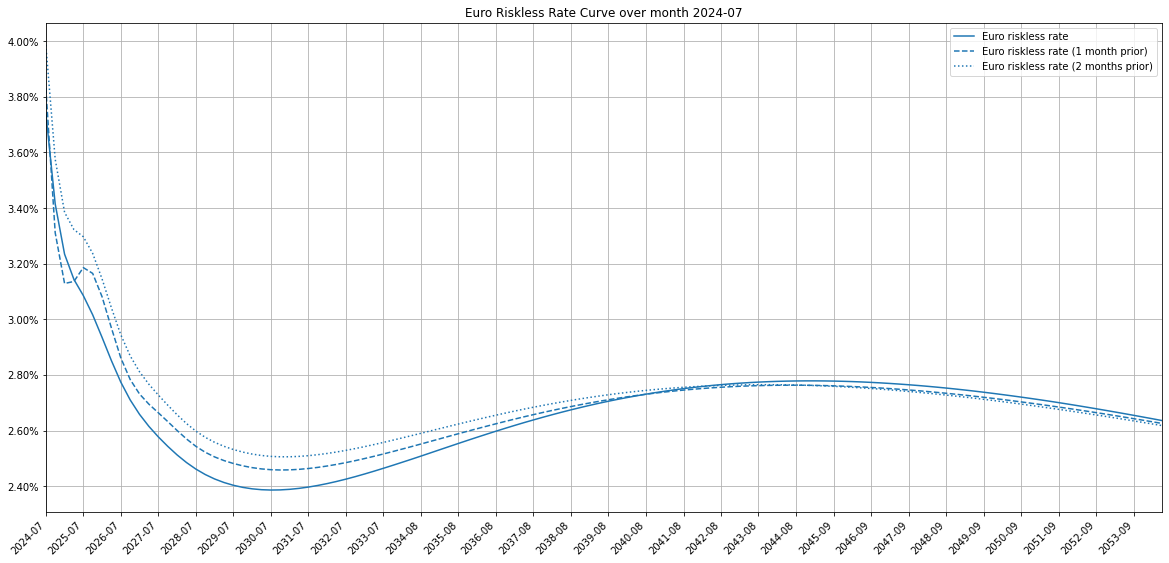

In [33]:
ax = df.iloc[:,0:1].plot(figsize=(20,10), grid=True,
             title='Euro Riskless Rate Curve over month ' + date_now.strftime('%Y-%m'),
             xlim=(df.index[0], df.index[-1]), xticks=df.index[::4], xlabel='', rot=45)
df.iloc[:,1:2].plot(ax=ax, grid=True, xticks=df.index[::4], rot=45, linestyle='--', color=['#1f77b4'])
df.iloc[:,2:3].plot(ax=ax, grid=True, xticks=df.index[::4], rot=45, linestyle=':', color=['#1f77b4'])
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, df.index[::4])))

In [34]:
print('An average shift of {:+.2f}bps between {:%Y-%m} and {:%Y-%m} across maturities'.format(
    (df.iloc[:,0]-df.iloc[:,1]).mean() * 10000,
    euro_spot_rates.index[-1].date(), euro_spot_rates.index[-2].date()))

An average shift of -1.95bps between 2024-07 and 2024-06 across maturities


In [35]:
year_split = date(2033, 11, 1)

In [36]:
print('An average shift of {:+.2f}bps between {:%Y-%m} and {:%Y-%m} for maturities up to {:%Y-%m}'.format(
    (df.loc[:year_split,df.columns[0]]-df.loc[:year_split,df.columns[1]]).mean() * 10000,
    euro_spot_rates.index[-1].date(), euro_spot_rates.index[-2].date(), year_split))

An average shift of -6.69bps between 2024-07 and 2024-06 for maturities up to 2033-11


In [37]:
print('An average shift of {:+.2f}bp between {:%Y-%m} and {:%Y-%m} for maturities from {:%Y-%m}'.format(
    (df.loc[year_split:,df.columns[0]]-df.loc[year_split:,df.columns[1]]).mean() * 10000,
    euro_spot_rates.index[-1].date(), euro_spot_rates.index[-2].date(), year_split))

An average shift of +0.24bp between 2024-07 and 2024-06 for maturities from 2033-11


In [38]:
offset_in_years = 3

In [39]:
print('Average short-term (<{:d}y) riskless yield: {:.2%}'.format(offset_in_years,
    df.loc[:(euro_spot_rates.index[-1].date()+relativedelta(years=+offset_in_years)),df.columns[0]].mean()))

Average short-term (<3y) riskless yield: 3.02%


In [40]:
print('Average long-term (>{:d}y) riskless yield: {:.2%}'.format(offset_in_years,
    df.loc[(euro_spot_rates.index[-1].date()+relativedelta(years=+offset_in_years)):,df.columns[0]].mean()))

Average long-term (>3y) riskless yield: 2.64%


In [41]:
print('Long-term (>{:d}y) riskless yield: {:.2%}-{:.2%}'.format(offset_in_years,
    df.loc[(euro_spot_rates.index[-1].date()+relativedelta(years=+offset_in_years)):,df.columns[0]].min(),
    df.loc[(euro_spot_rates.index[-1].date()+relativedelta(years=+offset_in_years)):,df.columns[0]].max()))

Long-term (>3y) riskless yield: 2.39%-2.78%


In [42]:
df.iloc[:,0:1].max()

Euro riskless rate   3.7416%
dtype: float64

In [43]:
df.iloc[:,0:1].min()

Euro riskless rate   2.3865%
dtype: float64

In [44]:
df.iloc[:,0:1].idxmin()

Euro riskless rate   2030-07-19
dtype: datetime64[ns]

In [45]:
df.iloc[-1,0]-df.iloc[-1,2]

0.00018060000000000298